In [27]:
import sys
ars_path = "/home/boittier/pydcm/"
sys.path.insert(1, ars_path)
from pydcm import *

# The Gaussian-format cube file containing electron density:
refDensCube="/home/boittier/B.pdb/SCAN_1_2_3_4_S_36_10.0/18_SCAN/B.d.cube"
# The Gaussian-format cube file containing electrostatic potential energy:
refPotCube="/home/boittier/B.pdb/SCAN_1_2_3_4_S_36_10.0/18_SCAN/B.p.cube"
# The root folder for your fitting project
projDir="/home/boittier/pydcm/models/fbutadiene-18"
# The bin directory containing the MDCM scripts and programs
refBinDir="/home/boittier/pydcm/bin"
# The total charge of the molecule to be fitted (a.u.)
qtot=0.0
# The port to use for the local web browser (to view molecules in NGL). Make sure nobody else is using it already!
webPort='8885'
# The name of a Slurm partition allowing jobs to run for up to 2 hours with 4 cores
shortQ='vshort'
longQ='infinite'
# The desired isodensity surface to use for viewing potential energy surfaces (a.u)
isoSurf=0.001


# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Maximum number of charges to fit per atom (minimum is fixed at 1)
maxAChg=4

minMChg=18
maxMChg=54

natm=10
nfrag = 4

# Define fragments using atom numbering from NGL window at top of notebook
frags=[[9, 10, 4],[3,8],[7,2],[5,1,6]]
# Minimum number of charges to fit for each fragment (can average fewer than 1 per atom)
minFChg=[3,2,2,3]
# Maximum number of charges to fit for each fragment (upper limit per atom fixed by maxAChg)
maxFChg=[12,8,8,12]



workdir = projDir + '/'
refdir = workdir + 'ref/'
htmldir = workdir + 'html/'
bindir = refBinDir + '/'
pdbfile = refdir + 'mol.pdb'
densCube = refdir + os.path.basename(refDensCube)
potCube = refdir + os.path.basename(refPotCube)

In [28]:
pydcm = Pydcm(projDir, refBinDir, refDensCube, refPotCube, webPort, frags, minFChg, maxFChg, maxAChg, minMChg, maxMChg, shortQ, longQ)

In [29]:
pydcm.make_ref_directory()
pydcm.start_server()

Changed to working directory /home/boittier/pydcm/models/fbutadiene-18/
10 atoms in molecule
writing PDB file /home/boittier/pydcm/models/fbutadiene-18/ref/mol.pdb

Running jobs:python /home/boittier/pydcm/bin/simple-cors-http-server.py 8885
0 : run_http()

Web server running in directory /home/boittier/pydcm/models/fbutadiene-18, URLs are relative to this path

If you change the project directory, you need to restart Jupyter-Lab to restart this server and create a new root for URLs


In [30]:
pydcm.show_ref_models()

ESP range: -0.0376363 to 0.0376363 a.u.
8885 /home/boittier/pydcm/models/fbutadiene-18/html/ /home/boittier/pydcm/models/fbutadiene-18/ref/mol.pdb
http://localhost:8885/html/refESP.html


In [22]:
pydcm.display_mtpfit_comparison()

/home/boittier/pydcm/bin/mtpfit.py



## 1Charges Per Atom:
Atom 1 final RMSE: 1.446928536 kcal/mol
Atom 2 final RMSE: 2.07993862 kcal/mol
Atom 3 final RMSE: 3.498692228 kcal/mol
Atom 4 final RMSE: 3.211602896 kcal/mol
Atom 5 final RMSE: 1.196851843 kcal/mol
Atom 6 final RMSE: 0.8629574152 kcal/mol
Atom 7 final RMSE: 1.558089887 kcal/mol
Atom 8 final RMSE: 1.622695458 kcal/mol
Atom 9 final RMSE: 1.040344206 kcal/mol
Atom 10 final RMSE: 1.422295607 kcal/mol

## 2Charges Per Atom:
Atom 1 final RMSE: 0.9044939257 kcal/mol
Atom 2 final RMSE: 0.9555555014 kcal/mol
Atom 3 final RMSE: 0.5418775349 kcal/mol
Atom 4 final RMSE: 1.044094666 kcal/mol
Atom 5 final RMSE: 0.6421105077 kcal/mol
Atom 6 final RMSE: 0.3933102831 kcal/mol
Atom 7 final RMSE: 0.9201649474 kcal/mol
Atom 8 final RMSE: 0.9661994525 kcal/mol
Atom 9 final RMSE: 0.75884556 kcal/mol
Atom 10 final RMSE: 0.5113665347 kcal/mol

## 3Charges Per Atom:
Atom 1 final RMSE: 0.1803202494 kcal/mol
Atom 2 final RMSE: 0.3205186466 kcal/mol
Atom 3 final RMSE: 0.2357224029 kcal/mol

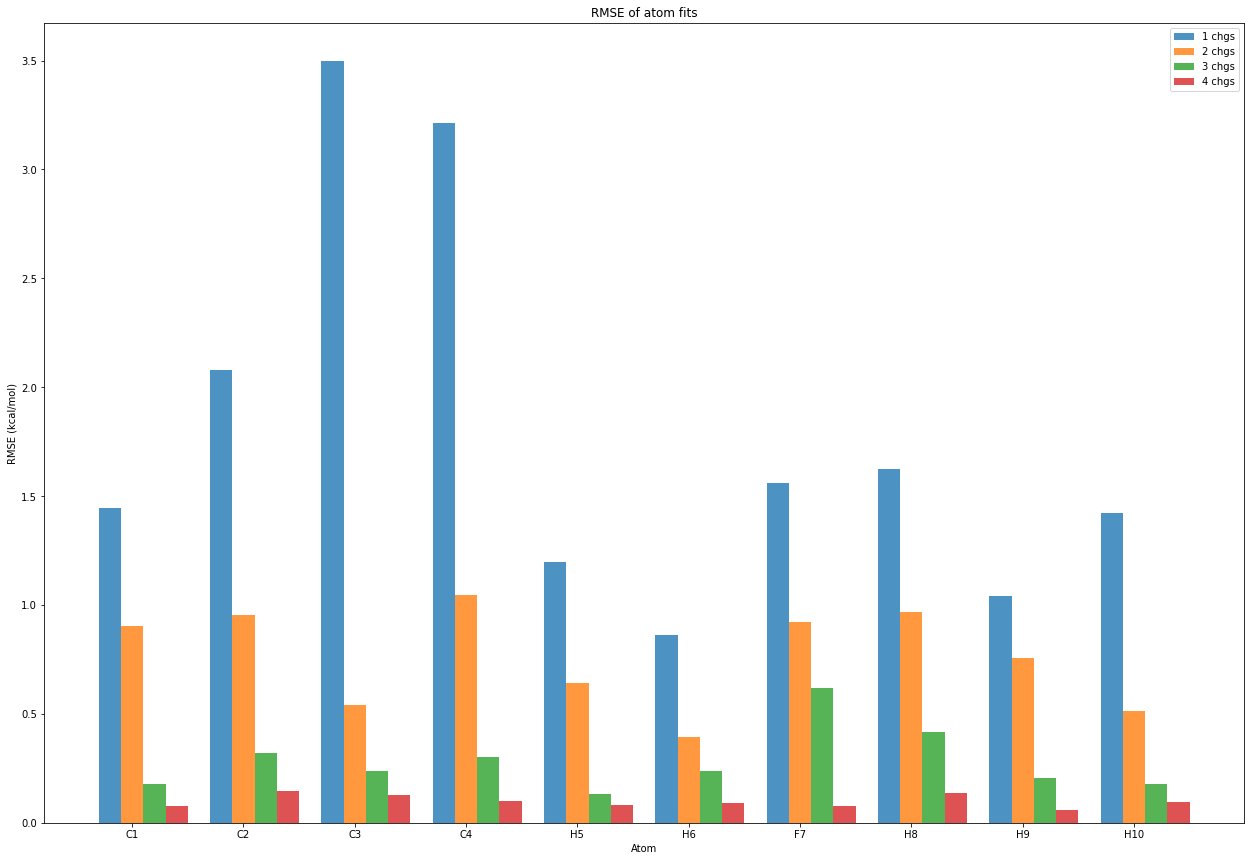

In [23]:
pydcm.do_atom_fit(maxAChg, ntry, nfrag)

Frag 1 fit 1, 13 charges: Job 3483037 is still running
Frag 1 fit 2, 12 charges: Job 3483038 is still running
Frag 1 fit 2, 13 charges: Job 3483039 is still running
Frag 4 fit 1, 13 charges: Job 3483040 is still running
Frag 4 fit 2, 13 charges: Job 3483041 is still running

Summary of results:
Frag 1, Fit 1, 3 charges, RMSE: 0.2847404266 kcal/mol
Frag 1, Fit 1, 4 charges, RMSE: 0.2123768735 kcal/mol
Frag 1, Fit 1, 5 charges, RMSE: 0.09770287991 kcal/mol
Frag 1, Fit 1, 6 charges, RMSE: 0.1613453696 kcal/mol
Frag 1, Fit 1, 7 charges, RMSE: 0.1152112674 kcal/mol
Frag 1, Fit 1, 8 charges, RMSE: 0.1188496332 kcal/mol
Frag 1, Fit 1, 9 charges, RMSE: 0.08075024882 kcal/mol
Frag 1, Fit 1, 10 charges, RMSE: 0.0656993169 kcal/mol
Frag 1, Fit 1, 11 charges, RMSE: 0.05583223066 kcal/mol
Frag 1, Fit 2, 3 charges, RMSE: 0.2847404269 kcal/mol
Frag 1, Fit 2, 4 charges, RMSE: 0.2123768787 kcal/mol
Frag 1, Fit 2, 5 charges, RMSE: 0.09770223234 kcal/mol
Frag 1, Fit 2, 6 charges, RMSE: 0.1130569041 kcal/

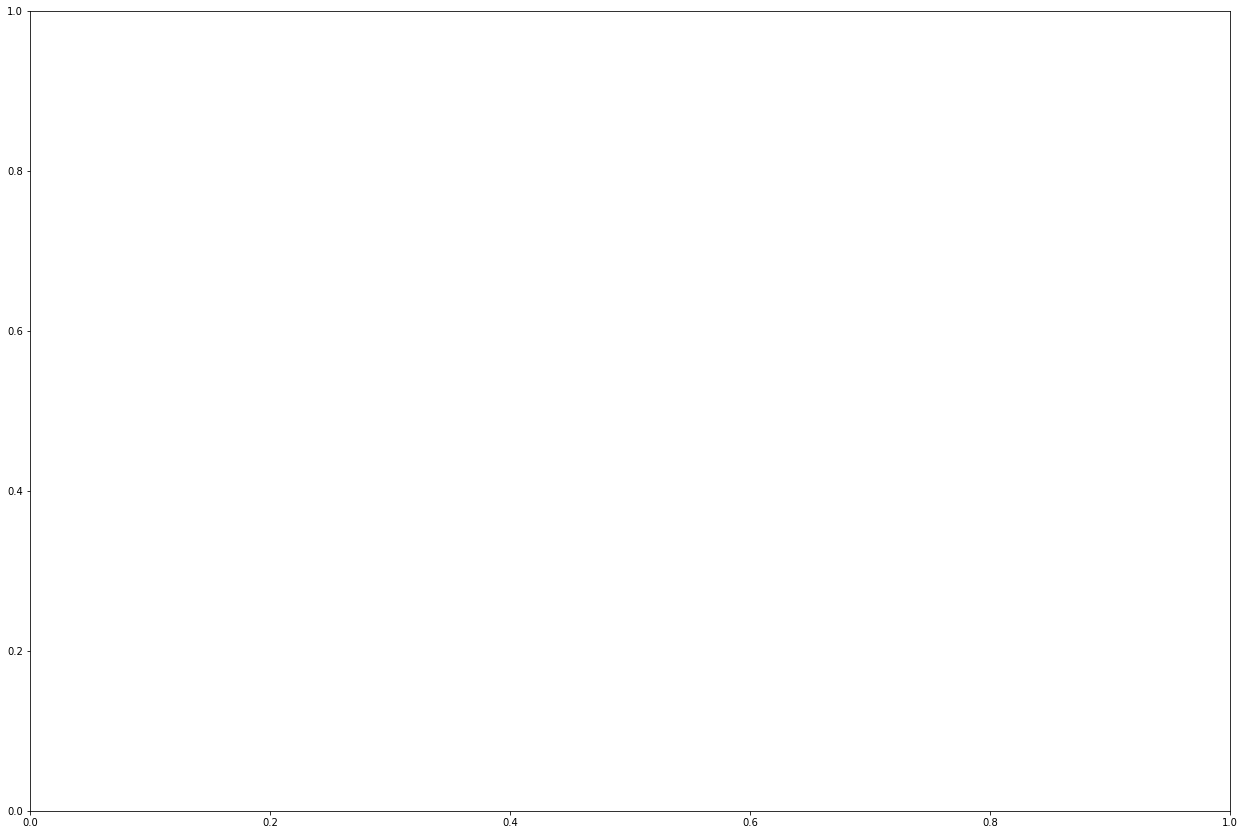

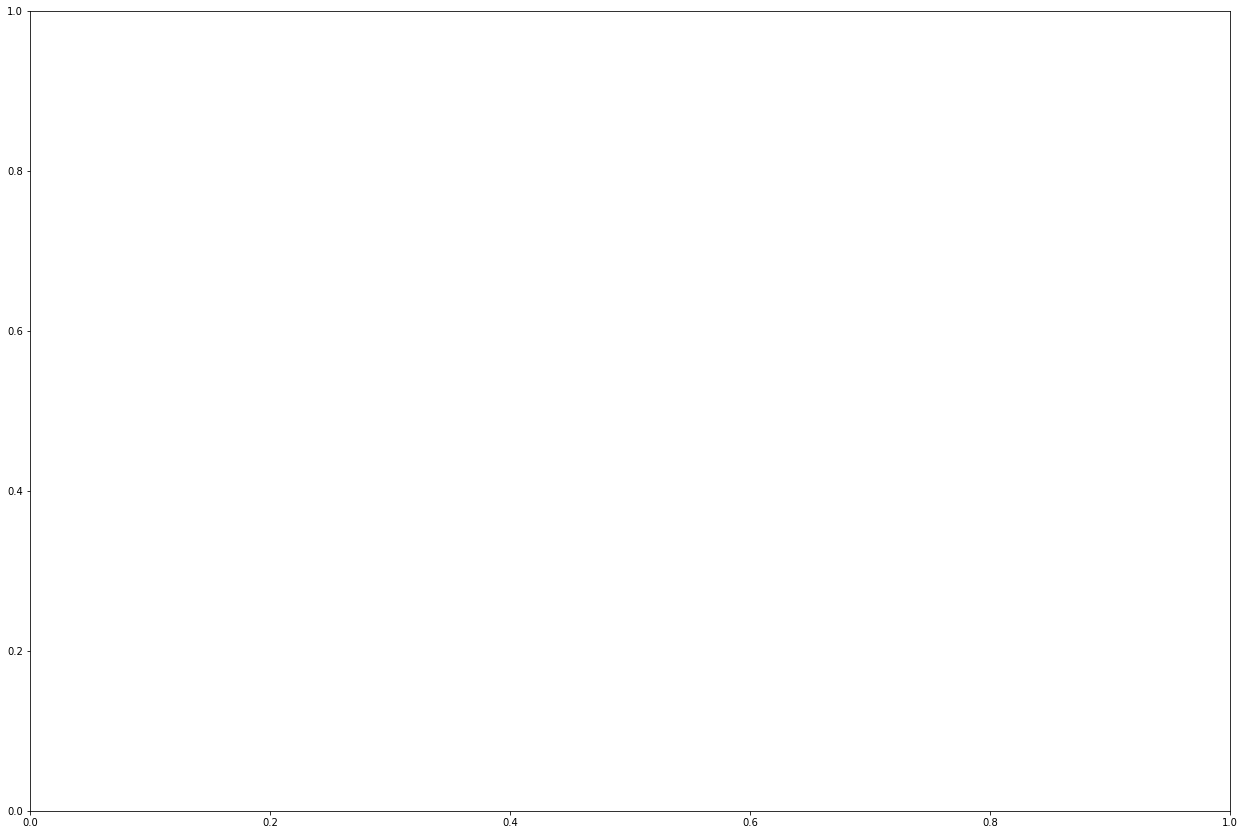

In [24]:
# START OF USER VARIABLES

# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Number of separate fits to perform (restarting a fit can lead to a better outcome). Cost scales linearly
nfit=2


pydcm.fit_fragments(ntry, nfit)

In [25]:
pydcm.combine_fragements(ntry, nfit)

18 CHARGES:
NEW BEST 18 charges: 3 2 2 11 rmse = 0.46152734081749996
NEW BEST 18 charges: 3 2 3 10 rmse = 0.439400666065
NEW BEST 18 charges: 3 2 4 9 rmse = 0.39098037409749997
NEW BEST 18 charges: 3 2 5 8 rmse = 0.38164243675
NEW BEST 18 charges: 3 2 6 7 rmse = 0.36395823465
NEW BEST 18 charges: 3 2 7 6 rmse = 0.359280288675
NEW BEST 18 charges: 3 2 8 5 rmse = 0.33783157869249997
NEW BEST 18 charges: 3 3 2 10 rmse = 0.33003995769
NEW BEST 18 charges: 3 3 3 9 rmse = 0.3103913884975
NEW BEST 18 charges: 3 3 4 8 rmse = 0.2678766378
NEW BEST 18 charges: 3 3 5 7 rmse = 0.253372701825
NEW BEST 18 charges: 3 3 6 6 rmse = 0.23823546767499998
NEW BEST 18 charges: 3 3 7 5 rmse = 0.22881629644999998
NEW BEST 18 charges: 3 3 8 4 rmse = 0.22760826511749999
NEW BEST 18 charges: 3 4 6 5 rmse = 0.21624552014999998
NEW BEST 18 charges: 5 3 5 5 rmse = 0.21458866365999998
NEW BEST 18 charges: 5 4 4 5 rmse = 0.20929690941
19 CHARGES:
NEW BEST 19 charges: 3 2 2 12 rmse = 25000.195169337574
NEW BEST 19 cha

Job 3483209 has crashed, resubmitting
submitted jobID 3484013
Job 3483210 has crashed, resubmitting
submitted jobID 3484014
No model with 41charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 42charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 43charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 44charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 45charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 46charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 47charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 48charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 49charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No model with 50charges exists in /home/boittier/pydcm/models/fbutadiene-18/4-combine/
No mod

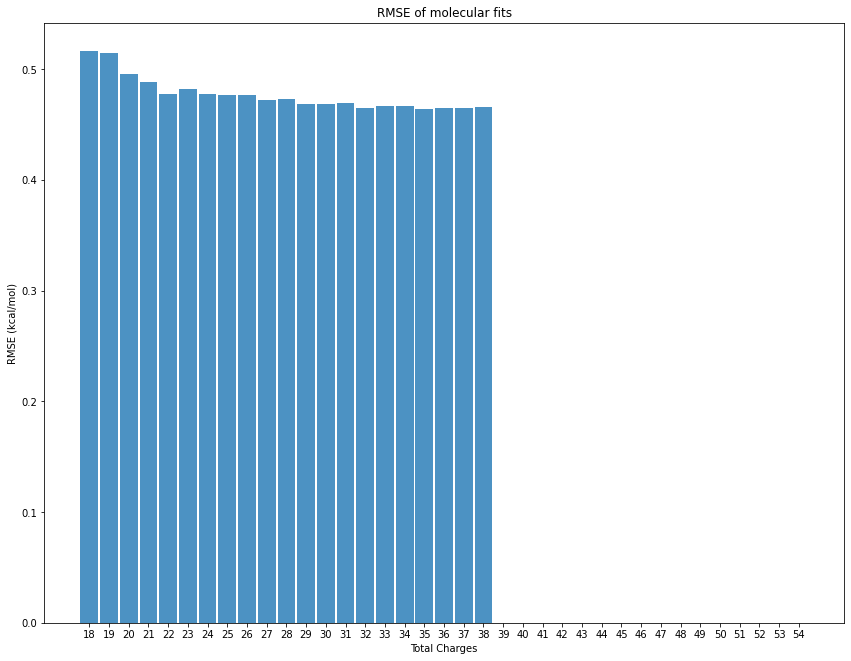

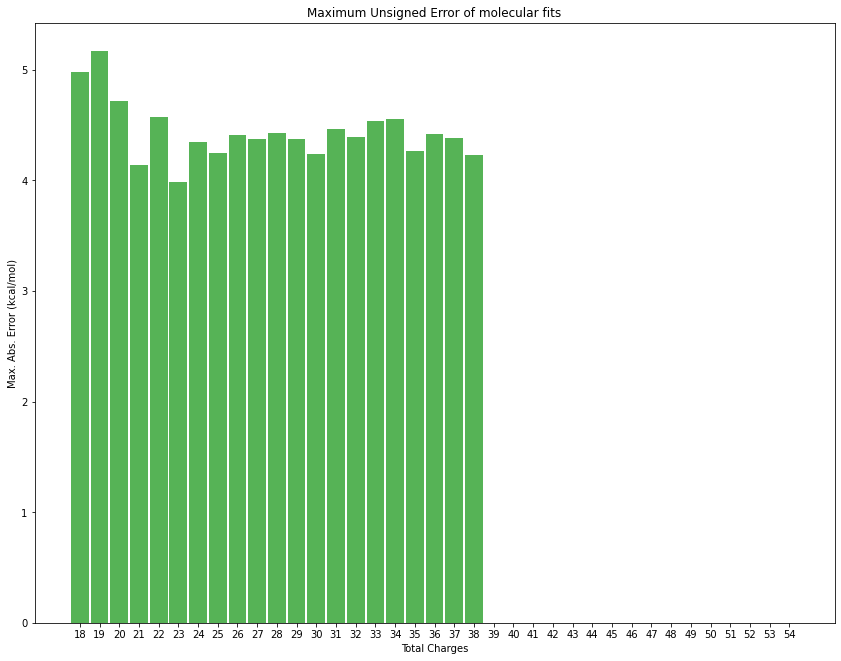

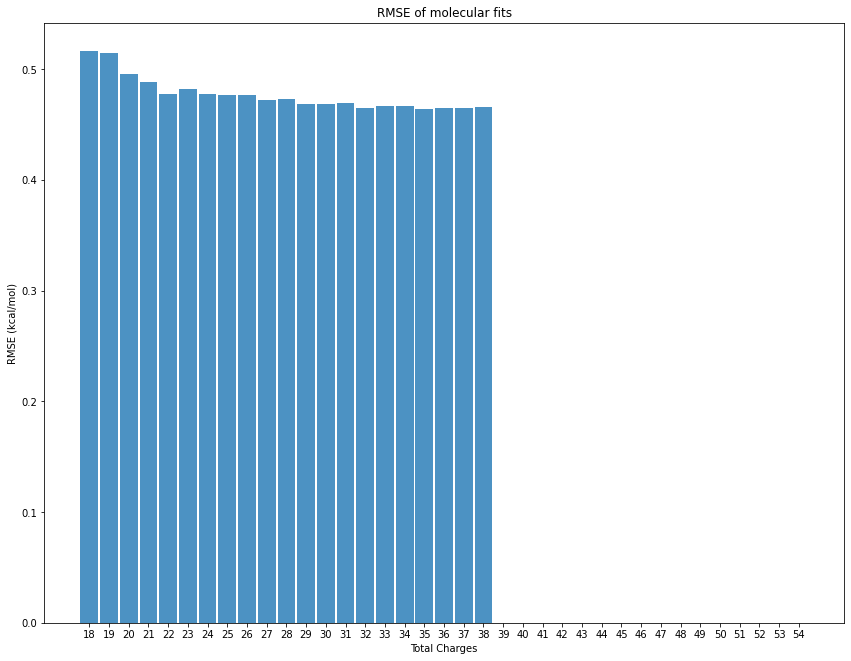

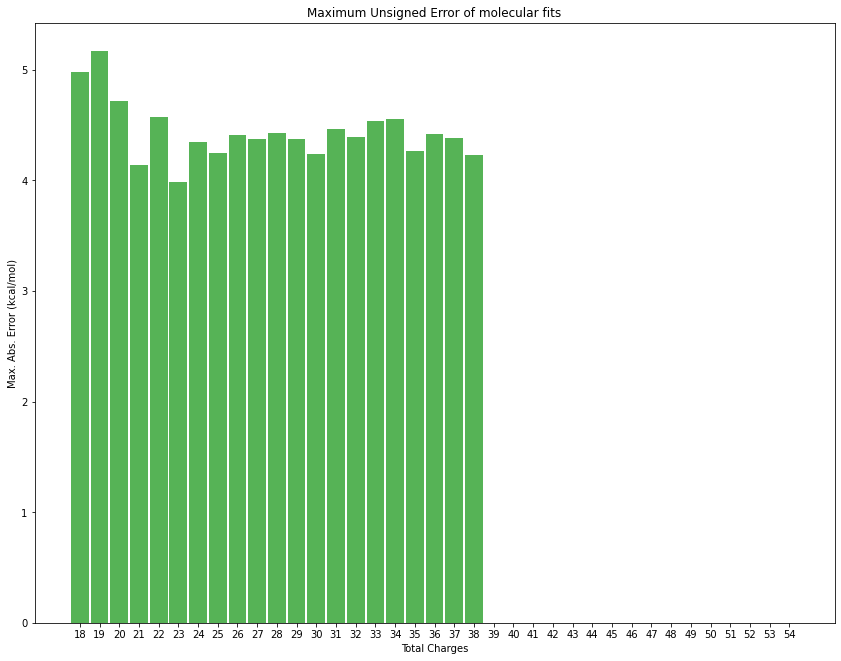

In [26]:
pydcm.refine_models()